In [332]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import spearmanr
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

import numpy as np

## 1.1

### Cargar el dataset

In [333]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data"
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df = pd.read_csv(url, header=None, delimiter=r"\s+", names=column_names)

# Muestra las primeras filas del DataFrames
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


### Dividir el dataset

In [334]:
# split the df into 80 20 using train_test_split
X = df.drop('MEDV', axis=1)
y = df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Modelo 1

In [335]:
# Estandarizar las variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Convertir a DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

### Distancia de Mahalanobis
Usando el vector de medianas y la matriz de correlación de Spearman para calcular la Distancia de Mahalanobis.

In [336]:
def mahalanobis_distance(x, medians, inv_cov_matrix):
    delta = x - medians
    return np.sqrt(np.dot(np.dot(delta, inv_cov_matrix), delta))


In [337]:
# matriz de correlación de Spearman
spearman_corr = spearmanr(X_train_scaled).correlation

# Invertir la matriz de correlación para usar en la fórmula de la distancia de Mahalanobis
inv_cov_matrix = np.linalg.inv(spearman_corr)

# Calcular el vector de medianas
medians = X_train_scaled.median().values

# Aplicar la función mahalanobis_distance a cada fila del DataFrame
X_train_scaled['mahalanobis'] = X_train_scaled.apply(mahalanobis_distance, axis=1, args=(medians, inv_cov_matrix))

X_train_scaled.head()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,mahalanobis
220,-0.372574,-0.499608,-0.704925,3.664502,-0.424879,0.935678,0.693669,-0.437218,-0.162242,-0.561656,-0.484638,0.371691,-0.411000,4.359109
71,-0.397099,-0.499608,-0.044878,-0.272888,-1.241859,-0.491181,-1.835528,0.730055,-0.624648,-0.573376,0.336491,0.205012,-0.387681,3.694088
240,-0.402693,0.771168,-0.886760,-0.272888,-1.111490,0.857849,-0.524621,1.234769,-0.393445,-0.602677,-0.849584,0.366609,-0.181919,3.285733
6,-0.405769,0.029882,-0.465819,-0.272888,-0.277127,-0.417676,-0.086464,0.861527,-0.509046,-0.538216,-1.488240,0.415732,-0.037886,3.422002
417,2.774932,-0.499608,0.998884,-0.272888,1.070021,-1.438097,0.715042,-1.021528,1.687378,1.542121,0.792674,-2.613393,1.911362,5.191490


In [338]:
X_train_scaled.shape
y_train.shape

(404,)

In [339]:
# Filtrar atípicos
threshold = np.percentile(X_train_scaled['mahalanobis'], 95)
X_train_clean = X_train_scaled[X_train_scaled['mahalanobis'] < threshold]

# Filtrar los valores de y_train correspondientes a los outliers
y_train_clean = y_train.loc[X_train_clean.index]

In [340]:
X_train_clean = X_train_clean.drop('mahalanobis', axis=1)
X_train_clean.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
220,-0.372574,-0.499608,-0.704925,3.664502,-0.424879,0.935678,0.693669,-0.437218,-0.162242,-0.561656,-0.484638,0.371691,-0.411000
71,-0.397099,-0.499608,-0.044878,-0.272888,-1.241859,-0.491181,-1.835528,0.730055,-0.624648,-0.573376,0.336491,0.205012,-0.387681
240,-0.402693,0.771168,-0.886760,-0.272888,-1.111490,0.857849,-0.524621,1.234769,-0.393445,-0.602677,-0.849584,0.366609,-0.181919
6,-0.405769,0.029882,-0.465819,-0.272888,-0.277127,-0.417676,-0.086464,0.861527,-0.509046,-0.538216,-1.488240,0.415732,-0.037886
417,2.774932,-0.499608,0.998884,-0.272888,1.070021,-1.438097,0.715042,-1.021528,1.687378,1.542121,0.792674,-2.613393,1.911362


### Modelo Elastic-Net

In [341]:
# Ranggos de hiperparámetros
l1_ratios = np.linspace(0.1, 0.9, 9)
alphas = np.logspace(-4, 0, 10)

In [342]:
#modelo ElasticNetCV
elastic_net_cv = ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=5, random_state=0)
results = elastic_net_cv.fit(X_train_clean, y_train_clean)

In [343]:
y_pred = results.predict(X_train_clean)
residuals = y_train_clean - y_pred
residuals

220   -6.374384
71    -0.200929
240   -5.616937
6     -0.370732
417    4.003765
         ...   
323   -0.510318
192    2.644900
117   -4.388670
47    -1.846922
172    1.051573
Name: MEDV, Length: 383, dtype: float64

In [344]:
# Mejores parámetros encontrados
print("Mejor l1_ratio:", elastic_net_cv.l1_ratio_)
print("Mejor alpha:", elastic_net_cv.alpha_)

Mejor l1_ratio: 0.1
Mejor alpha: 0.046415888336127774


#### Ecuación Modelo 1

In [345]:
# Coeficientes del modelo
coefficients = elastic_net_cv.coef_

# Intercepción
intercept = elastic_net_cv.intercept_

# Nombres de las columnas (variables)
features = X_train.columns

# Construir la ecuación en formato de texto
regression_eq = f"MEDV = {intercept:.4f}"
for coef, feature in zip(coefficients, features):
    regression_eq += f" + ({coef:.4f})*{feature}"

print("Ecuación de regresión:")
print(regression_eq)


Ecuación de regresión:
MEDV = 22.5676 + (-0.6722)*CRIM + (0.5963)*ZN + (-0.1327)*INDUS + (0.8066)*CHAS + (-1.3970)*NOX + (3.2617)*RM + (-0.2837)*AGE + (-2.3649)*DIS + (1.0197)*RAD + (-1.0033)*TAX + (-2.0776)*PTRATIO + (0.7784)*B + (-3.2308)*LSTAT


### Evaluar el Modelo 1

In [346]:
# Estandarizar el conjunto de prueba
X_test_scaled = scaler.transform(X_test)

# Realizar predicciones con el modelo ajustado
y_pred = elastic_net_cv.predict(X_test_scaled)

/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(


In [347]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE en el conjunto de prueba:", rmse)

RMSE en el conjunto de prueba: 5.8309678417663315


- El modelo 1 tiene un RMSE de **5.83**
- El RMSE de 5.79 es menor que la desviación estándar de MEDV (9.07). Esto es una buena señal y sugiere que tu modelo está realizando predicciones razonablemente precisas. Generalmente, si el RMSE es menor que la desviación estándar, se considera que el modelo tiene una precisión aceptable.
- El RMSE es aproximadamente el 26% del valor medio de MEDV (5.79 / 22.22 ≈ 0.26). Esto nos da una idea de que el error promedio de las predicciones es una cuarta parte del valor medio de las propiedades, lo cual puede ser aceptable dependiendo de tus requisitos de precisión.

In [348]:
# get average and scale of MEDV from the test set
average_MEDV = y_test.mean()
scale_MEDV = y_test.std()
print("Average MEDV:", average_MEDV)
print("Scale MEDV:", scale_MEDV)

Average MEDV: 22.21960784313725
Scale MEDV: 9.068332880459835


### Evaluación de supuestos 

#### Prueba de independencia

In [349]:
# Prueba de INDEPENDENCIA

durbin_watson_statistic = sm.stats.stattools.durbin_watson(residuals)
print("Estadístico de Durbin-Watson:", durbin_watson_statistic)

Estadístico de Durbin-Watson: 1.962791086454944


- El valor de 1.9628 indica  que hay muy poca o ninguna evidencia de autocorrelación en los residuos del modelo 1. 
- Significa que la información en los residuos de una observación no proporciona información sobre los residuos de otra
- El supuesto de independencia se cumple

#### Prueba de normalidad

In [350]:
import scipy.stats as stats

# Prueba de Shapiro-Wilk
shapiro_test_statistic, shapiro_p_value = stats.shapiro(residuals)
print("Shapiro-Wilk Test:")
print("Statistic =", shapiro_test_statistic, ", P-value =", shapiro_p_value)

# Prueba de Anderson-Darling
anderson_test = stats.anderson(residuals, dist='norm')
print("\nAnderson-Darling Test:")
print("Statistic =", anderson_test.statistic)
print("Significance Levels:", anderson_test.significance_level)
print("Critical Values:", anderson_test.critical_values)


Shapiro-Wilk Test:
Statistic = 0.8873714804649353 , P-value = 3.7296785020583887e-16

Anderson-Darling Test:
Statistic = 8.077231479638954
Significance Levels: [15.  10.   5.   2.5  1. ]
Critical Values: [0.57  0.649 0.779 0.909 1.081]


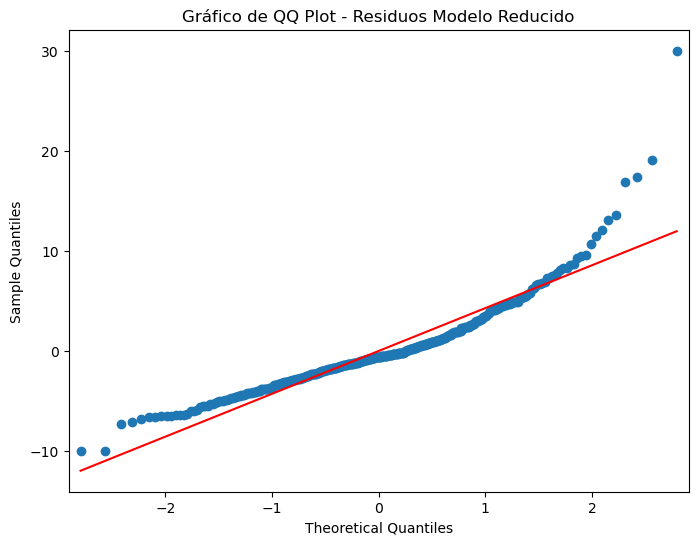

In [351]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot

fig, ax = plt.subplots(figsize=(8, 6))
qqplot(residuals, line='s', ax=ax)
ax.set_title('Gráfico de QQ Plot - Residuos Modelo Reducido')
plt.show()

- Los puntos en los extremos, tanto en el lado izquierdo como derecho, se desvían significativamente de la línea roja.
- Esta desviación es particularmente notable en los cuantiles más altos, donde los residuos son mucho más grandes de lo que se esperaría bajo una distribución normal.
- Estadístico: 0.887, bastante menor que 1, indicando que la distribución de los residuos no sigue la forma de una distribución normal.
- P-valor: extremadamente pequeño (3.73e-16), mucho menor que cualquier umbral convencional como 0.05, rechazando fuertemente la hipótesis nula de normalidad.
- Ambas pruebas, junto con la visualización del QQ Plot, indican que los residuos del modelo 1 no están distribuidos normalmente. Esta falta de normalidad puede deberse a varios factores, como la presencia de atípicos, una especificación incorrecta del modelo, o variables explicativas que no capturan completamente la dinámica de la variable dependiente.



#### Prueba de media cero

In [352]:

t_statistic, p_valor = stats.ttest_1samp(residuals, 0)


print("Estadístico t:", t_statistic)
print("P-Value:", p_valor)

Estadístico t: 8.744724475259841e-15
P-Value: 0.999999999999993


Los resultados indican que los residuos deL modelo 1 satisfacen el supuesto de tener una media de cero de manera adecuada. Este es un indicativo positivo que sugiere que el modelo no tiene sesgo sistemático en las predicciones que genera.

#### Homocedasticidad

In [353]:
residuals

220   -6.374384
71    -0.200929
240   -5.616937
6     -0.370732
417    4.003765
         ...   
323   -0.510318
192    2.644900
117   -4.388670
47    -1.846922
172    1.051573
Name: MEDV, Length: 383, dtype: float64

In [354]:
X_train_clean_scaled = scaler.fit_transform(X_train_clean)
X_train_clean_scaled = pd.DataFrame(X_train_clean_scaled, columns=X_train_clean.columns)

# Añadir constante a la matriz de predictores limpios y estandarizados
X_incl_const = sm.add_constant(X_train_clean_scaled)

# Ahora realizar la prueba de Breusch-Pagan
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, X_incl_const)
print("Breusch-Pagan test:")
print("Lagrange Multiplier statistic:", bp_test[0])
print("p-value:", bp_test[1])

Breusch-Pagan test:
Lagrange Multiplier statistic: 50.49154717975578
p-value: 2.454695897630938e-06


In [355]:
residuals_sorted = residuals.sort_index()
residuals_sorted

0     -6.521502
2      3.525466
3      4.088816
4      7.315551
5      3.199688
         ...   
500   -3.817587
501   -1.544832
502   -1.567982
503   -3.807359
504   -4.210348
Name: MEDV, Length: 383, dtype: float64

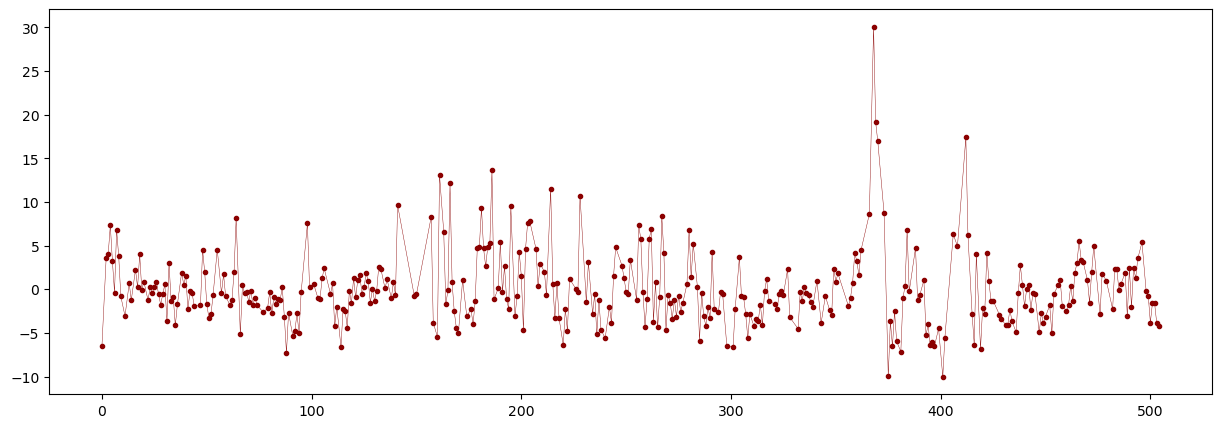

In [356]:
plt.figure(figsize=(15,5))
plt.plot(residuals_sorted, '.-', color ="darkred", linewidth=0.3)
plt.show()

- Estadístico de Lagrange Multiplier: 50.4915
	- Es relativamente alto, lo cual sugiere que las variaciones en las predicciones del modelo 1 están asociadas con variaciones en la magnitud de los errores (residuos), es decir, la varianza de los residuos no es constante.
- Existe heterocedasticidad en los residuos del modelo 1.

## Modelo 2

In [357]:
n = X_train_scaled.shape[0]
p = X_train_scaled.shape[1] - 1
k = int((n + p + 1) / 2)

In [362]:
# Seleccionar las observaciones con las distancias más pequeñas
X_train_clean = X_train_scaled.nsmallest(k, 'mahalanobis')
y_train_clean = y_train.loc[X_train_clean.index]
X_train_clean.drop('mahalanobis', axis=1, inplace=True)

In [363]:
l1_ratios = np.linspace(0.1, 0.9, 9)
alphas = np.logspace(-4, 0, 10)

# Crear y entrenar el modelo ElasticNetCV
elastic_net_cv = ElasticNetCV(l1_ratio=l1_ratios, alphas=alphas, cv=5, random_state=0)
elastic_net_cv.fit(X_train_clean, y_train_clean)

# Mejores parámetros encontrados
print("Mejor l1_ratio:", elastic_net_cv.l1_ratio_)
print("Mejor alpha:", elastic_net_cv.alpha_)

Mejor l1_ratio: 0.9
Mejor alpha: 0.0001


In [364]:
X_test_scaled = scaler.transform(X_test)
y_pred = elastic_net_cv.predict(X_test_scaled)

# Calcular el RMSE para evaluar la precisión del modelo
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE en el conjunto de prueba:", rmse)


RMSE en el conjunto de prueba: 1968.5469934562582


/Users/danielmartinezvillegas/anaconda3/envs/personal/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but ElasticNetCV was fitted with feature names
  warnings.warn(


#### Ecuación Modelo 2

In [366]:
# Coeficientes del modelo
coefficients = elastic_net_cv.coef_

# Intercepción
intercept = elastic_net_cv.intercept_

# Nombres de las columnas (variables)
features = X_train.columns

# Construir la ecuación en formato de texto
regression_eq = f"MEDV = {intercept:.4f}"
for coef, feature in zip(coefficients, features):
    regression_eq += f" + ({coef:.4f})*{feature}"

print("Ecuación de regresión:")
print(regression_eq)

Ecuación de regresión:
MEDV = 21.0545 + (-2.5097)*CRIM + (-1.1046)*ZN + (0.1574)*INDUS + (-0.0000)*CHAS + (-2.8625)*NOX + (4.0804)*RM + (-1.4765)*AGE + (-3.3920)*DIS + (3.3828)*RAD + (-3.4802)*TAX + (-1.4525)*PTRATIO + (-0.7409)*B + (-1.5369)*LSTAT


In [365]:
y_pred = results.predict(X_train_clean)
residuals = y_train_clean - y_pred
residuals

309   -2.845551
312   -3.384617
318   -1.393379
313   -3.582518
500   -3.817587
         ...   
458   -1.923526
473    4.952109
165   -0.123496
167    0.802213
408    4.920649
Name: MEDV, Length: 209, dtype: float64